# dev nearest-neighbor tracking with periodic boundary conditions
Tim Tyree<br>
6.29.2022

In [1]:
# use_clear_output=True
# if use_clear_output:
#     from IPython.display import clear_output
#     clear_output(wait=True)

import sys,os
og_stdout=sys.stdout
from lib.my_initialization import *

os.chdir(nb_dir)
from lib import *

# import cupy, cudf
# from lib.rapids_func import *

import seaborn as sns
import matplotlib.ticker as mtick

#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

import warnings
warnings.simplefilter("ignore", UserWarning)
%load_ext autoreload
%autoreload 2

In [2]:
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

# define module

In [3]:
# def load_tip_pos_from_csv(input_dir,round_t_to_n_digits=7,t_col='t',
#                           reset_index=True,printing=True,**kwargs):
#     """
#     Example Usage:
# df=load_tip_pos_from_csv(input_dir,round_t_to_n_digits=7,printing=True)
#     """
#     df=pd.read_csv(input_dir)
#     df[t_col]=np.around(df[t_col],round_t_to_n_digits)
#     if printing:
#         print(f"{df.shape=}")
#     df.drop_duplicates(inplace=True)
#     if printing:
#         print(f"{df.shape=}")
#     if reset_index:
#         df.reset_index(inplace=True)
#     return df

In [4]:
# def find_nearest_neighbor_simple(xy,xy_others,distance_L2_pbc):
#     """returns (nearest_id,nearest_dist) from xy_others, where distance is computed by distance_L2_pbc.
#     note that distance_L2_pbc does not necessarily need to be the L2 norm with periodic boundary conditions.
#     distance_L2_pbc has the signature:
#     dist = distance_L2_pbc ( xy_others[j], xy)
    
#     Example Usage:    
# distance_L2_pbc = get_distance_L2_pbc(width=width,height=height)
# nearest_id, nearest_dist = find_nearest_neighbor_simple(xy,xy_others,distance_L2_pbc)
#     """
#     num_other=xy_others.shape[0]
#     nearest_id   =  -1
#     nearest_dist = 9999.
#     for j in range(num_other):
#         dist = distance_L2_pbc ( xy_others[j], xy)
#         if dist<nearest_dist:
#             nearest_dist = dist
#             nearest_id  = j
#     return nearest_id, nearest_dist

In [5]:
# def comp_consistent_nearest_neighbors(map_prev_next,map_next_prev):
#     """for each key of map_prev_next, look for consistent nearest neighbors
#     map_prev_next and map_next_prev are dictionaries that map indices from prev to/from next, respectively.
    
#     Example Usage:
# id_pair_lst=comp_consistent_nearest_neighbors(map_prev_next,map_next_prev)
# dict_map_prev_next_consistent=dict(id_pair_lst)
#     """
#     id_pair_lst=[]
#     for key_next in map_next_prev:
#         key_prev=map_next_prev[key_next]
#         if map_prev_next[key_prev]==key_next:
#             #record key match
#             id_pair_lst.append((key_prev,key_next))
#     return id_pair_lst

In [373]:
# def find_nearest_neighbor_map(d_prev,d_next,distance_L2_pbc,xy_col_lst=['x','y'],**kwargs):
#     """find_nearest_neighbors_pbc returns a list of pairs of indices, where each pair indexes 
#     a member of d_prev and d_next that are mutually nearest neighbors, respectively.
#     distance_L2_pbc is passed to find_nearest_neighbor_simple directly
#     Example Usage:
# map_prev_next_disp_consistent,map_prev_next_disp=find_nearest_neighbor_map(d_prev,d_next,distance_L2_pbc)#,xy_col_lst=['x','y'],**kwargs)
#     """
#     #extract positions
#     xy_prev=d_prev[xy_col_lst].values.copy()
#     xy_next=d_next[xy_col_lst].values.copy()
#     #compute the map from prev to next
#     map_prev_next={}
#     map_prev_next_disp={}
#     for i,xy_self in enumerate(xy_prev):
#         #compute the nearest neighbor
#         nearest_id, nearest_dist = find_nearest_neighbor_simple(xy=xy_self,xy_others=xy_next,distance_L2_pbc=distance_L2_pbc)
#         map_prev_next[i]=nearest_id
#         map_prev_next_disp[i]=nearest_dist
#     #compute the map from next to prev
#     map_next_prev={}
#     for i,xy_self in enumerate(xy_next):
#         #compute the nearest neighbor
#         nearest_id, nearest_dist = find_nearest_neighbor_simple(xy=xy_self,xy_others=xy_prev,distance_L2_pbc=distance_L2_pbc)
#         map_next_prev[i]=nearest_id
#     id_pair_lst=comp_consistent_nearest_neighbors(map_prev_next,map_next_prev)
#     map_prev_next_disp_consistent=dict(id_pair_lst)
#     return map_prev_next_disp_consistent,map_prev_next_disp

In [372]:
# def find_nearest_neighbors_simple(d_prev,d_next,distance_L2_pbc,xy_col_lst=['x','y'],**kwargs):
#     """find_nearest_neighbors_pbc returns a list of pairs of indices, where each pair indexes 
#     a member of d_prev and d_next that are mutually nearest neighbors, respectively.
#     distance_L2_pbc is passed to find_nearest_neighbor_simple directly
#     Example Usage:
# id_pair_lst=find_nearest_neighbors_simple(d_prev,d_next,distance_L2_pbc)#,xy_col_lst=['x','y'],**kwargs)
#     """
#     #extract positions
#     xy_prev=d_prev[xy_col_lst].values.copy()
#     xy_next=d_next[xy_col_lst].values.copy()
#     #compute the map from prev to next
#     map_prev_next={}
#     map_prev_next_disp={}
#     for i,xy_self in enumerate(xy_prev):
#         #compute the nearest neighbor
#         nearest_id, nearest_dist = find_nearest_neighbor_simple(xy=xy_self,xy_others=xy_next,distance_L2_pbc=distance_L2_pbc)
#         map_prev_next[i]=nearest_id
#         map_prev_next_disp[i]=nearest_dist
#     #compute the map from next to prev
#     map_next_prev={}
#     #map_next_prev_disp={}
#     for i,xy_self in enumerate(xy_next):
#         #compute the nearest neighbor
#         nearest_id, nearest_dist = find_nearest_neighbor_simple(xy=xy_self,xy_others=xy_prev,distance_L2_pbc=distance_L2_pbc)
#         map_next_prev[i]=nearest_id
#         #map_next_prev_disp[i]=nearest_dist
#     id_pair_lst=comp_consistent_nearest_neighbors(map_prev_next,map_next_prev)
#     disp_pair_lst=[map_prev_next_disp[x[0]] for x in id_pair_lst]
#     return id_pair_lst,disp_pair_lst

In [682]:
# def track_particle_annihilations_pbc_nearest_neighbors_simple(df,width,height,
#                                                             min_num_obs=3,
#                                                             round_t_to_n_digits=7,
#                                                             max_dist=None,
#                                                             max_disp=None,
#                                                             use_final_annihilation=True,
#                                                             printing=True,
#                                                             **kwargs):
#     """df is a pd.DataFrame instance with fields: 'x','y','frame', and 'n', where 'n' denotes the current number of particles.
#     df is endowed with fields indexing pair-annihilation events.
#     if 'frame' is missing, than it is inferred from 't', which we assume to have equal time increments.
    
    
#     Example Usage:
# df=track_particle_annihilations_pbc_nearest_neighbors_simple(df,width,height,
#                                                             min_num_obs=3,round_t_to_n_digits=7,
#                                                             max_dist=None,max_disp=None,
#                                                             use_final_annihilation=True,
#                                                             printing=True)#,**kwargs)
#     """
#     if max_dist is None:
#         max_dist=width/10 #pixels
#     if max_disp is None:
#         max_disp=max_dist/2 #pixels

#     #jit compile distance function
#     distance_L2_pbc = get_distance_L2_pbc(width=width,height=height)
#     if df.shape[0]<=min_num_obs:
#         if printing:
#             print(f"Warning: termination event occured before {min_num_obs=} were recorded... returning None")
#         return None
#     boo_in_domain = (df['x'].max()<=width)&(df['y'].max()<=height)
#     boo_in_domain&= (df['x'].min()>=0)&(df['y'].min()>=0)
#     if not boo_in_domain:
#         #test that the positions are within the computational domain
#         if printing:
#             print(f"Warning: particle positions were recorded outside of the computational domain... returning None")
#         return None

#     #define 'frame' field if it doesn't already exist
#     if not set(df.columns).issuperset({'frame'}):
#         #DT shouldn't be needed utnil the end. use frames instead, unless if it makes getting frames easy
#         DT=np.max(np.diff(df['t'].drop_duplicates().values))
#         # #DONE: test method of computing frame number works
#         # assert (np.around((df[t_col]/DT+1),round_t_to_n_digits).astype(int)==df['frame']).all()
#     #     df['frame']=np.around((df[t_col]/DT+1),round_t_to_n_digits).astype(int)
#         df['frame']=np.around((df['t']/DT+1),round_t_to_n_digits).astype(int)

#     #initialize field 'particle'
#     df['index_self']=-9999
#     df['index_other']=-9999
#     df['dist']=-9999. #distance in pixels

#     frame_min=df['frame'].min()
#     frame_max=df['frame'].max()

#     #compute n(t)
#     df_n=df.groupby(by='frame')['n'].median().astype('int')
#     boo_annihilation=df_n.diff()==-2 #for n-2 only (simple)
#     # boo_annihilation=df_n.diff()<0 #for n-2 and n-4 events (complicated)

#     #identify all annihilation events where n --> n-2
#     boo_annihiations_exist=boo_annihilation.any()
#     if not boo_annihiations_exist:
#         if printing:
#             print("Warning: no annihilations were found.")
#         return None

#     # #DONE: print confirmation that the mean n value is an integer numerically
#     # df_n=df.groupby(by=t_col)['n'].mean()
#     # print(np.unique(df_n.values))

#     #DONE: identify all transition frames
#     #identify all transition times
#     frame_annihilation_values=df_n[boo_annihilation].index.values
#     frame_annihilation_lst=list((df_n[boo_annihilation].index.values))

#     if use_final_annihilation:
#         #compute the first frame when n=0, supposing it is not present in the frame_values
#         #note: if this step fails, try the (~complicated) workaround of checking for n=0 in the df
#         #note: one row per position does not support n=0 anywhere
#         assert not (df['n']==0).any()
#         assert (df.tail(1)['n']==2).all()
#         #frame_final=(df.tail(1)['frame']+1).values[0]
#         frame_final=df['frame'].max()+1
#         frame_annihilation_lst.append(frame_final)

#     #sort the annihilation events in reverse order
#     frame_annihilation_lst=sorted(frame_annihilation_lst,reverse=True)
#     if printing:
#         print(f"tracking {len(frame_annihilation_lst)} potential annihilation events...")

#     index_annihilation=0
#     for frame_annihilation in frame_annihilation_lst:
#         frame_next=frame_annihilation
#         frame_prev=frame_next-1
#         #extract data from frame_prev,frame_next
#         #boo_available=(df['index_self']<0)&(df['index_other']<0)
#         #d_prev=df[(df['frame']==frame_prev)&boo_available].copy()
#         d_prev=df[(df['frame']==frame_prev)].copy()
#         num_prev=d_prev.shape[0]
#         if frame_annihilation<=frame_max:
#             #extract d_next like normal
#             d_next=df[df['frame']==frame_next].copy()
#             num_next=d_next.shape[0]
#         else:
#             num_next=0

#         ###################################
#         # initialize new tips
#         ###################################
#         # if (num_next==0)|(num_prev==2): #could cause more edge cases than it fixes...
#         if (num_next==0):#&(num_prev==2):
#             # #identify the new pair if trivial case
#             # id_values_prev_new=np.arange(d_prev.shape[0])
#             # id_self=id_values_prev_new[0]
#             # id_other=id_values_prev_new[1]
#             id_self =0  # d_prev.head(1).index.values[0]
#             id_other=1 # d_prev.tail(1).index.values[0]
#         else:
#             # #otherwise identify the new pair in general pbc case
#             #find_nearest_neighbors
#             id_pair_lst,disp_pair_lst=find_nearest_neighbors_simple(d_prev,d_next,distance_L2_pbc)#,xy_col_lst=['x','y'],**kwargs)
#             #identify which two indices are new in the previous frame
#             id_pair_values=np.array(id_pair_lst)
#             id_values_prev_taken=id_pair_values[:,0]
#             id_values_prev=np.arange(d_prev.shape[0])
#             id_values_prev_new=np.setdiff1d(id_values_prev,id_values_prev_taken)
#             id_self=id_values_prev_new[0]
#             id_other=id_values_prev_new[1]
#         index_values_prev=d_prev.index.values
#         index_self=index_values_prev[id_self]
#         index_other=index_values_prev[id_other]
#         xy_self=df.loc[index_self,['x','y']].values
#         xy_other=df.loc[index_other,['x','y']].values
#         dist=distance_L2_pbc(xy_self,xy_other)
#         if dist>max_dist:
#             num_obs=0
#             working=False
#         else:
#             # initialize next setting
#             num_obs=1
#             working=True
#             #DONE: add check to set working=False if the initial distance between particles is greater than a certain amount
#             #record new tips to self and other
#             df.loc[index_self,'dist']=dist
#             df.loc[index_self,'index_self']=index_annihilation
#             df.loc[index_other,'index_other']=index_annihilation
#             #compute distance between self and other only
#         #end initialization of new tips

#         ##########################################
#         # generate annihilating trajectories only
#         ##########################################
#         # while previous positions are found, grow only the trajectories involved in this annihilation event
#         while working:
#             #time step backward
#             frame_next=frame_prev
#             frame_prev=frame_prev-1
#             #break if end of data
#             if frame_prev<=frame_min:
#                 working=False

#             #extract data from frame_prev,frame_next
#             boo_available=(df['index_self']<0)&(df['index_other']<0)
#             boo = (df['frame']==frame_prev)&boo_available
#             if not boo.any():
#                 working = False
#             else:
#                 d_prev=df[boo].copy()
#                 #limit d_next to only consider values that have not been assigned to a particle or the just assigned particles
#                 boo_annihilation=(df['index_self']==index_annihilation)|(df['index_other']==index_annihilation)
#                 boo_available_next=boo_available|boo_annihilation
#                 d_next=df[((df['frame']==frame_next)&boo_available_next)].copy()
#                 map_next_prev_disp_consistent,map_next_prev_disp=find_nearest_neighbor_map(d_next,d_prev,distance_L2_pbc)#,xy_col_lst=['x','y'],**kwargs)

#                 # #DONE: plot the points i just initialized and verify they look reasonable relative to d_prev, d_next
#                 # fig,ax=plt.subplots(figsize=(5,5))
#                 # df[df['index_self']==index_annihilation].plot.scatter(x='x',y='y',ax=ax,color='r',alpha=0.6,marker='v',s=100)
#                 # df[df['index_other']==index_annihilation].plot.scatter(x='x',y='y',ax=ax,color='r',alpha=0.6,marker='^',s=100)
#                 # d_prev.plot.scatter(x='x',y='y',ax=ax,color='C0',alpha=0.2,marker='o',s=300)
#                 # d_next.plot.scatter(x='x',y='y',ax=ax,color='C1',alpha=0.2,marker='o',s=300)
#                 # # df.loc[index_other].plot.scatter(x='x',y='y',ax=ax,color='r',alpha=0.6)
#                 # plt.xlim([0,width])
#                 # plt.ylim([0,height])
#                 # plt.show()

#                 #determine whether there was a successful match for either particle
#                 id_self = int(np.argwhere(d_next['index_self'].values==index_annihilation))
#                 id_other = int(np.argwhere(d_next['index_other'].values==index_annihilation))
#                 id_matched_next=set(map_next_prev_disp_consistent.keys())
#                 boo_self_matched=id_matched_next.issuperset({id_self})
#                 boo_other_matched=id_matched_next.issuperset({id_other})
#                 #if both matched,
#                 if (boo_self_matched&boo_other_matched):
#                     ######################
#                     #update both 
#                     ######################
#                     index_values_prev=d_prev.index.values
#                     index_self_prev  = index_values_prev[map_next_prev_disp_consistent[id_self]]
#                     index_other_prev = index_values_prev[map_next_prev_disp_consistent[id_other]]
#                     #determine whether either displacement is reasonably small
#                     displacement_self = map_next_prev_disp[id_self]
#                     displacement_other = map_next_prev_disp[id_other]
#                     if not ((displacement_self<max_disp)&(displacement_other<max_disp)):
#                         working = False
#                     else:
#                         #record new tips to self and other
#                         df.loc[index_self_prev,'index_self']=index_annihilation
#                         df.loc[index_other_prev,'index_other']=index_annihilation
#                 elif boo_self_matched:
#                     ######################
#                     #update self and look for a match for other, terminating if other found no such match
#                     ######################
#                     index_values_prev=d_prev.index.values
#                     index_values_next=d_next.index.values
#                     index_self_prev  = index_values_prev[map_next_prev_disp_consistent[id_self]]
#                     index_self_next  = index_values_next[id_self]
#                     #index_other_prev = index_values_prev[map_next_prev_disp_consistent[id_other]]
#                     #determine whether either displacement is reasonably small
#                     displacement_self = map_next_prev_disp[id_self]
#                     #displacement_other = map_next_prev_disp[id_other]
#                     if displacement_self>max_disp:
#                         working = False
#                     else:
#                         #record new tips to self
#                         df.loc[index_self_prev,'index_self']=index_annihilation
#                         #update d_prev,d_next to not include self
#                         index_values_prev=d_prev.index.values
#                         index_values_next=d_next.index.values
#                         d_prev = d_prev[index_values_prev!=index_self_prev].copy()
#                         d_next = d_next[index_values_next!=index_self_next].copy()
#                         #look for neighbors, as before
#                         map_next_prev_disp_consistent,map_next_prev_disp=find_nearest_neighbor_map(d_next,d_prev,distance_L2_pbc)#,xy_col_lst=['x','y'],**kwargs)
#                         #determine if other matched
#                         id_other = int(np.argwhere(d_next['index_other'].values==index_annihilation))
#                         id_matched_next=set(map_next_prev_disp_consistent.keys())
#                         boo_other_matched=id_matched_next.issuperset({id_other})
#                         #if other did not match, terminate
#                         if not boo_other_matched:
#                             working=False
#                         else:
#                             #update other
#                             index_values_prev=d_prev.index.values
#                             index_other_prev = index_values_prev[map_next_prev_disp_consistent[id_other]]
#                             #determine whether either displacement is reasonably small
#                             displacement_other = map_next_prev_disp[id_other]
#                             if displacement_other>max_disp:
#                                 working = False
#                             else:
#                                 #record to other
#                                 df.loc[index_other_prev,'index_other']=index_annihilation
#                 elif boo_other_matched:
#                     ######################
#                     #update other and look for a match for self, terminating if self found no such match
#                     ######################
#                     index_values_prev=d_prev.index.values
#                     index_values_next=d_next.index.values
#                     index_other_prev  = index_values_prev[map_next_prev_disp_consistent[id_other]]
#                     index_other_next  = index_values_next[id_other]
#                     #determine whether either displacement is reasonably small
#                     displacement_other = map_next_prev_disp[id_other]
#                     if displacement_other>max_disp:
#                         working = False
#                     else:
#                         #record new tips to other
#                         df.loc[index_other_prev,'index_other']=index_annihilation
#                         #update d_prev,d_next to not include other
#                         index_values_prev=d_prev.index.values
#                         index_values_next=d_next.index.values
#                         d_prev = d_prev[index_values_prev!=index_other_prev].copy()
#                         d_next = d_next[index_values_next!=index_other_next].copy()
#                         #look for neighbors, as before
#                         map_next_prev_disp_consistent,map_next_prev_disp=find_nearest_neighbor_map(d_next,d_prev,distance_L2_pbc)#,xy_col_lst=['x','y'],**kwargs)
#                         #determine if self matched
#                         id_self = int(np.argwhere(d_next['index_self'].values==index_annihilation))
#                         id_matched_next=set(map_next_prev_disp_consistent.keys())
#                         boo_self_matched=id_matched_next.issuperset({id_self})
#                         #if self did not match, terminate
#                         if not boo_self_matched:
#                             working=False
#                         else:
#                             #update self
#                             index_values_prev=d_prev.index.values
#                             index_self_prev = index_values_prev[map_next_prev_disp_consistent[id_self]]
#                             #determine whether either displacement is reasonably small
#                             displacement_self = map_next_prev_disp[id_self]
#                             if displacement_self>max_disp:
#                                 working = False
#                             else:
#                                 #record to self
#                                 df.loc[index_self_prev,'index_self']=index_annihilation
#                 else:
#                     working=False
#                 if working:
#                     #compute distance between self and other only
#                     xy_self=df.loc[index_self_prev,['x','y']].values
#                     xy_other=df.loc[index_other_prev,['x','y']].values
#                     dist=distance_L2_pbc(xy_self,xy_other)
#                     df.loc[index_self_prev,'dist']=dist
#                     #record increment to num_obs
#                     num_obs+=1
#         #end while
#         if min_num_obs>num_obs:
#             #reset any instance of index_annihilation to null in 'index_self' and 'index_other'
#             if printing:
#                 print(f"Warning: {num_obs=} < {min_num_obs=}.  removed {index_annihilation=} from dataframe")
#             df.loc[df['index_self']==index_annihilation,'index_self']=-9999
#             df.loc[df['index_self']==index_annihilation,'dist']=-9999
#             df.loc[df['index_other']==index_annihilation,'index_other']=-9999
#         else:
#             #keep this annihilation
#             index_annihilation+=1
#             #move on to the next annihilation event
#         #end for loop over annihilating trajectories
#     #end generation annihilating trajectories
#     return df

In [683]:
# def compute_annihilation_range_timeseries(df,DS=0.025, #cm/s
#                                           **kwargs):
#     """compute t'=tdeath and verify R(t')=R for annihilation events indexed by index_self.
#     Example Usage:
# df=compute_annihilation_range_timeseries(df,DS=0.025)
#     """
#     df['R']=DS*df['dist']
#     df['tdeath']=np.nan
#     max_index_annihilation=df['index_self'].max()
#     for index_annihilation in range(max_index_annihilation):
#         d = df[(df['index_self']==index_annihilation)&(df['dist']>0)]
#         tf = d['t'].max()
#         df.loc[(df['index_self']==index_annihilation)&(df['dist']>0),'tdeath'] = tf - df['t']
#     return df

# parse a folder of fortranic tip positions

In [3]:
nb_dir

'/Users/timothytyree/Documents/GitHub/care/notebooks'

In [4]:
#parse WJ's fortranic spiral tip locations to a parquet cache.
input_dir=f'{nb_dir}/Data/from_wjr/tippos_per_001'
df_log=parse_fortranic_tip_pos(input_dir)
#partition df_log into a folder of tip logs
log_folder_parquet=f'{nb_dir}/Data/from_wjr/tippos_per_001_log/'
# save_df_to_parquet_by(df_log,log_folder_parquet,by='trial_num',compression='snappy',index=True)
save_df_to_parquet_by(df_log,log_folder_parquet,by='trial_num',compression='snappy',index=None)
print(f"saved to spiral tip positions to\n{log_folder_parquet=}")
#determine width and height of the computational domain input the discretization
width,height=df_log.describe().loc['max'][['x','y']].values.T

DT=df_log['t'].min()
printing=True
if printing:
    print(df_log.describe().loc[['min','max']][['x','y']])
    print(f"{width=}, {height=}, {DT=}")
del df_log
print(f"{log_folder_parquet=}")

saved to spiral tip positions to
log_folder_parquet='/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_log/'
         x      y
min    0.0    0.0
max  200.0  200.0
width=200.0, height=200.0, DT=1.0
log_folder_parquet='/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_log/'


In [571]:
# # #DONE: load the data from bgmc that has pid_explicit
# # #HINT: its on ub in bgmc/python/data/local_results
# # search_for_file()

# #linear particle model test case
# input_dir='/home/timothytyree/Documents/GitHub/bgmc/python/data/local_results/euic_False_fc_2_r_0.1_D_2_L_10_kappa_1500_varkappa_5/Log/pbc_particle_log2_log.csv'
# df=load_tip_pos_from_csv(input_dir,round_t_to_n_digits=round_t_to_n_digits,printing=False)
# round_t_to_n_digits=7
# min_num_obs=10
# min_dist=2. #pixels
# # width=200
# # height=200 
# width=10
# height=10
# from collections import deque

In [702]:
# def routine_compute_annihilation_range_timeseries_pbc(df,
#     width=200,
#     height=200,
#     max_disp=30, #15-1000 appears to work
#     max_dist=20, # appears to work
#     min_num_obs=1,
#     use_final_annihilation=True,
#     printing=True,**kwargs):
#     """
#     Example Usage: fortranic spiral tip model test case
# trial_num=638
# log_folder_parquet='/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_log/'
# df=load_parquet_by_trial_num(trial_num=trial_num,folder_parquet=log_folder_parquet)
# df_R=routine_compute_annihilation_range_timeseries_pbc(df,width=200,height=200,
#                 max_disp=30, #15-1000 appears to work
#                 max_dist=20, # appears to work
#                 min_num_obs=1,use_final_annihilation=True,printing=True)
# df_R.head()
#     """
#     df=track_particle_annihilations_pbc_nearest_neighbors_simple(df,width,height,
#                                                                 min_num_obs=min_num_obs,round_t_to_n_digits=7,
#                                                                 max_dist=max_dist,max_disp=max_disp,
#                                                                 use_final_annihilation=use_final_annihilation,
#                                                                 printing=printing)#,**kwargs)
#     df=compute_annihilation_range_timeseries(df,DS=0.025)
#     max_index_annihilation=df['index_self'].max()
#     if printing:
#         print(f"successfully tracked {max_index_annihilation+1} annihilation events!")
#     #format output
#     df_R=df.copy()
#     df_R.sort_values(by=['index_self','tdeath'],inplace=True)
#     df_R.dropna(inplace=True)
#     df_R.rename(columns={'index_self':'annihilation_index'},inplace=True)
#     df_R.drop(columns=['index','index_other','dist'],inplace=True)
#     column_deque = deque(df_R.columns)
#     column_deque.rotate(3)
#     return df_R[list(column_deque)]

# DONE: dev'd simple pbc nn particle tracker & tested on linear particle model
- TODO: test routine on fortranic data step by step
- TODO: wrap routine into function 
- TODO: test functional routine on fortranic data with new kernel

In [572]:
# min_num_obs=10
# min_dist=width/10 #pixels
# round_t_to_n_digits=7
#DONE: implement/dev draft of simple tracker like WJ's in physical notebook
#DONE: add support for creation events
#DONE: add support for a max displacement of particles
#TODO: test on WJ's fortranic tippos
#TODO: repeat with .copy() removed in often repeated locations.  does it still work the same?


In [5]:
#fortranic spiral tip model test case
trial_num=638
log_folder_parquet='/Users/timothytyree/Documents/GitHub/care/notebooks/Data/from_wjr/tippos_per_001_log/'
df=load_parquet_by_trial_num(trial_num=trial_num,folder_parquet=log_folder_parquet)
df_R=routine_compute_annihilation_range_timeseries_pbc(df,DS=0.025,width=200,height=200,
                max_disp=30, #15-1000 appears to work
                max_dist=20, # appears to work
                min_num_obs=1,use_final_annihilation=True,printing=True)
df_R.head()

tracking 47 potential annihilation events...
successfully tracked 47 annihilation events!


,annihilation_index,R,tdeath,t,n,x,y,trial_num,frame
8480,0,0.172790,0.0,1512.0,2,47.0,185.4,638,1513
8478,0,0.243323,1.0,1511.0,2,45.6,184.7,638,1512
8476,0,0.297374,2.0,1510.0,2,44.2,183.9,638,1511
8474,0,0.346888,3.0,1509.0,2,42.8,183.3,638,1510
8472,0,0.370312,4.0,1508.0,2,42.2,183.1,638,1509


In [695]:
itertools.starmap?

In [705]:
df=track_particle_annihilations_pbc_nearest_neighbors_simple(df,width=200,height=200,
                max_disp=30, #15-1000 appears to work
                max_dist=20, # appears to work
                min_num_obs=1,use_final_annihilation=True,printing=True)

tracking 47 potential annihilation events...


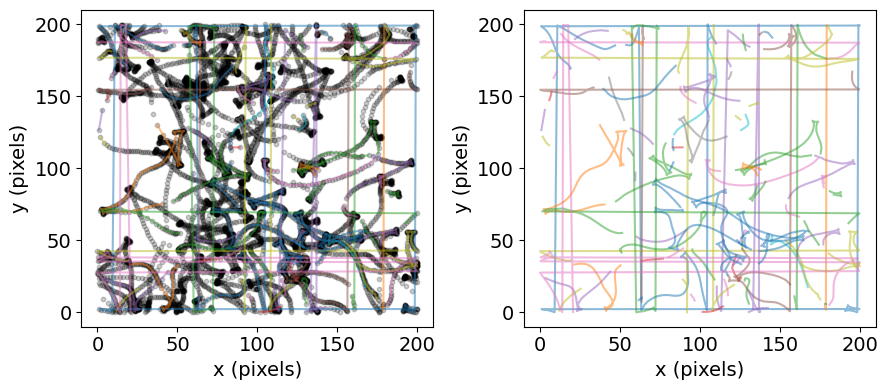

In [706]:
max_index_annihilation=df['index_self'].max()
fontsize=14
fig,axs=plt.subplots(ncols=2,figsize=(9,4))
ax=axs[0]
for index_annihilation in range(max_index_annihilation):
    df[df['index_self']==index_annihilation].plot(x='x',y='y',color=f'C{index_annihilation}',ax=ax,alpha=0.5,legend=None)
    df[df['index_other']==index_annihilation].plot(x='x',y='y',color=f'C{index_annihilation*2}',ax=ax,alpha=0.5,legend=None)
df.plot.scatter(x='x',y='y',color=f'k',ax=ax,alpha=0.2,legend=None,s=10)
format_plot(ax=ax,xlabel="x (pixels)",ylabel='y (pixels)', fontsize=fontsize)
ax=axs[1]
for index_annihilation in range(max_index_annihilation):
    df[df['index_self']==index_annihilation].plot(x='x',y='y',color=f'C{index_annihilation}',ax=ax,alpha=0.5,legend=None)
    df[df['index_other']==index_annihilation].plot(x='x',y='y',color=f'C{index_annihilation*2}',ax=ax,alpha=0.5,legend=None)

format_plot(ax=ax,xlabel="x (pixels)",ylabel='y (pixels)', fontsize=fontsize)
plt.tight_layout()
plt.show()

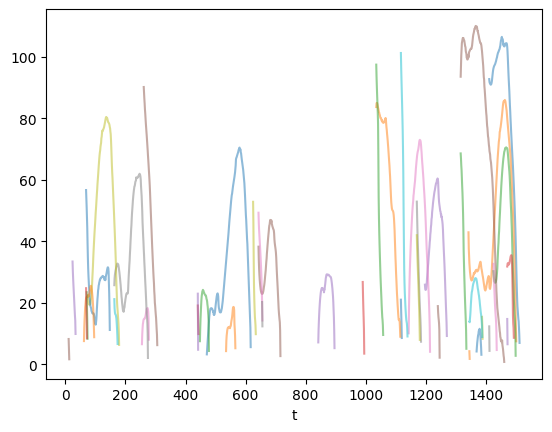

In [707]:
fig,ax=plt.subplots()
max_index_annihilation=df['index_self'].max()
for index_annihilation in range(max_index_annihilation):
    df[(df['index_self']==index_annihilation)&(df['dist']>0)].\
    plot(x='t',y='dist',color=f'C{index_annihilation}',ax=ax,alpha=0.5, legend=None)
# df.tail(8).plot.scatter(x='x',y='y',color='g',ax=ax)
# plt.legend()
plt.show()

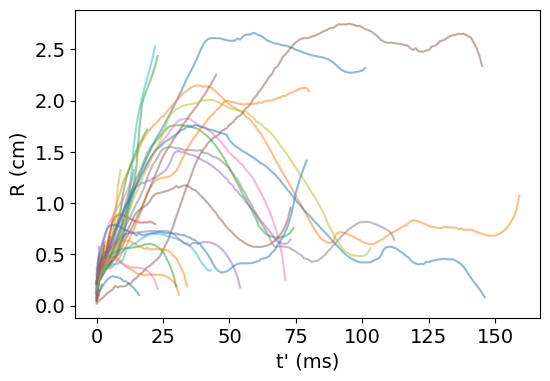

trial_num=638, max_disp=30


In [708]:
fontsize=14
df=compute_annihilation_range_timeseries(df,DS=0.025)
fig,ax=plt.subplots(figsize=(6,4))
max_index_annihilation=df['index_self'].max()
for index_annihilation in range(max_index_annihilation):
    df[(df['index_self']==index_annihilation)&(df['dist']>0)].\
    plot(x='tdeath',y='R',color=f'C{index_annihilation}',ax=ax,alpha=0.5, legend=None)
# df.tail(8).plot.scatter(x='x',y='y',color='g',ax=ax)
format_plot(ax=ax,xlabel="t' (ms)",ylabel='R (cm)', fontsize=fontsize)
plt.show()
print(f"{trial_num=}, {max_disp=}")

# old tests of dev on linear particle model

In [21]:
#reset matplotlib settings
import matplotlib as mpl
sns.reset_orig()
mpl.rc_file_defaults()

In [22]:
# index_annihilation_plot=index_annihilation-1
index_annihilation_plot=0
df.loc[df['index_other']==index_annihilation_plot,'index_other'].shape

(975,)

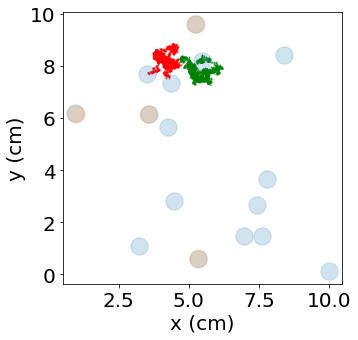

In [23]:
#plot the points i just computed and verify they look reasonable
fig,ax=plt.subplots(figsize=(5,5))
df[df['index_self']==index_annihilation_plot].plot.scatter(x='x',y='y',ax=ax,color='r',alpha=0.6,marker='v',s=2)
df[df['index_other']==index_annihilation_plot].plot.scatter(x='x',y='y',ax=ax,color='g',alpha=0.6,marker='^',s=2)
d_prev.plot.scatter(x='x',y='y',ax=ax,color='C0',alpha=0.2,marker='o',s=300)
d_next.plot.scatter(x='x',y='y',ax=ax,color='C1',alpha=0.2,marker='o',s=300)
format_plot(ax=ax,xlabel='x (cm)',ylabel='y (cm)')
plt.show()

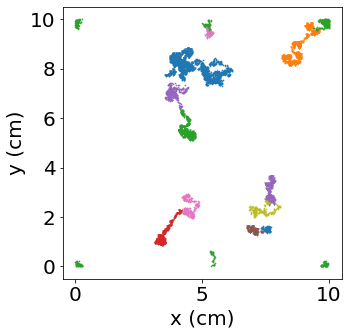

In [37]:
#plot the points i just computed and verify they look reasonable
fig,ax=plt.subplots(figsize=(5,5))
for index_annihilation_plot in range (8):
    df[df['index_self']==index_annihilation_plot].plot.scatter(x='x',y='y',ax=ax,color=f'C{index_annihilation_plot}',alpha=0.9,marker='v',s=2)
    df[df['index_other']==index_annihilation_plot].plot.scatter(x='x',y='y',ax=ax,color=f'C{index_annihilation_plot*2}',alpha=0.9,marker='.',s=2)
# d_prev.plot.scatter(x='x',y='y',ax=ax,color='C0',alpha=0.2,marker='o',s=300)
# d_next.plot.scatter(x='x',y='y',ax=ax,color='C1',alpha=0.2,marker='o',s=300)
format_plot(ax=ax,xlabel='x (cm)',ylabel='y (cm)')
plt.show()

In [24]:
#DONE: test for equivalence between my particle tracking and the ground truth
#HINT: make dict between particle and pid_explicit, asserting that particle maps to one and only one pid_explicit
#now the big test:
# index_annihilation_test=0
index_annihilation_test=index_annihilation_plot
print(f"Do no more than two known particle identities get assigned to {index_annihilation_test=}?")
pid_explicit_set_lst_self=list(set(df.loc[df['index_self']==index_annihilation_plot,'pid_explicit'].values))
pid_explicit_set_lst_other=list(set(df.loc[df['index_other']==index_annihilation_plot,'pid_explicit'].values))
print(f"{pid_explicit_set_lst_self=}")
print(f"{pid_explicit_set_lst_other=}")
print(f"{num_obs=} is greater than {min_num_obs=}, so this pair-annihilation event is _kept_.")

Do no more than two known particle identities get assigned to index_annihilation_test=0?
pid_explicit_set_lst_self=[3]
pid_explicit_set_lst_other=[7]
num_obs=98 is greater than min_num_obs=10, so this pair-annihilation event is _kept_.


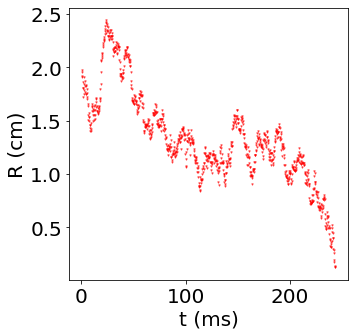

In [25]:
#TODO: simple test for whether results for an example R(t') look reasonable
#plot the points i just computed and verify they look reasonable
fig,ax=plt.subplots(figsize=(5,5))
d=df.loc[df['index_self']==index_annihilation_plot]
d.plot.scatter(x='t',y='dist',ax=ax,color='r',alpha=0.6,marker='v',s=2)
# df[df['index_self']==index_annihilation_plot].plot.scatter(x='x',y='y',ax=ax,color='r',alpha=0.6,marker='v',s=2)
# df[df['index_other']==index_annihilation_plot].plot.scatter(x='x',y='y',ax=ax,color='g',alpha=0.6,marker='^',s=2)
# d_prev.plot.scatter(x='x',y='y',ax=ax,color='C0',alpha=0.2,marker='o',s=300)
# d_next.plot.scatter(x='x',y='y',ax=ax,color='C1',alpha=0.2,marker='o',s=300)
format_plot(ax=ax,xlabel='t (ms)',ylabel='R (cm)')
plt.show()

In [26]:
#Q: why is the final; distance so far away?
#A: it's just where i killed the simulation, man! Don't worry about it
#TODO: add check to set working=False if the initial distance between particles is greater than a certain amount

In [27]:
d.tail()

,index,frame,t,n,x,y,pid_explicit,index_self,index_other,dist
7134,7134,972,242.75,4,4.590947,8.229685,3,0,-9999,0.197205
7138,7138,973,243.00,4,4.604876,8.229697,3,0,-9999,0.173529
7142,7142,974,243.25,4,4.614060,8.261937,3,0,-9999,0.123376
7146,7146,975,243.50,4,4.595442,8.228966,3,0,-9999,0.125009
7150,7150,976,243.75,4,4.587405,8.211438,3,0,-9999,0.132469


In [28]:
df.tail()

,index,frame,t,n,x,y,pid_explicit,index_self,index_other,dist
85199,85199,39999,9999.50,2,9.295363,6.435280,15,-9999,-9999,-9999.0
85200,85200,40000,9999.75,2,4.330187,3.962795,14,-9999,-9999,-9999.0
85201,85201,40000,9999.75,2,9.253390,6.452116,15,-9999,-9999,-9999.0
85202,85202,40001,10000.00,2,4.335643,3.967257,14,-9999,-9999,-9999.0
85203,85203,40001,10000.00,2,9.322021,6.518097,15,-9999,-9999,-9999.0


In [29]:
#DONE: ROOT CAUSE ANALYSIS: why is index 3 not being returned?
#YEP. #ROOT CAUSE IDENTIFIED: recall annihilating particles vibrate around eachother as they annihilate
#NOPE. #POTENTIAL ROOT CAUSE: map_prev_next,map_next_prev are not inverses of each other
# #simplest fix: recompute the other if either is found
# id_pair_lst=find_nearest_neighbors_simple(d_prev,d_next,distance_L2_pbc)#,xy_col_lst=['x','y'],**kwargs)
# assert len(id_pair_lst)==d_prev.shape[0]

In [30]:
#DONT(this would clearly break it): simple test for whether results for an example R(t') stop looking reasonable if i do:
# d_next=df[df['frame']==frame_next].copy()
# d_next=df[df['frame']==frame_next]